In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../src/")
import importlib
import structures
importlib.reload(structures)
from structures import *
#import losses
#importlib.reload(losses)
#from losses import *
#import trainer
#importlib.reload(trainer)
#from trainer import *
#dtype = torch.float32
#dtype = torch.double
dtype = torch.float32
torch.set_default_dtype(dtype)
torch.autograd.set_detect_anomaly(True)
# Set the device to CUDA if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#import deepspeed
import random
sys.path.append("/mnt/home/yjo10/ceph/myutils")
import plt_utils as pu

torch.cuda.empty_cache()
import gc
# Garbage collect
gc.collect()
# Cosine‑annealing with warmup
#from timm.scheduler import create_scheduler
from types import SimpleNamespace
from tqdm import tqdm


Using device: cuda


In [2]:
sys.path.append("../src/")
import importlib
import dataloader
importlib.reload(dataloader)
from dataloader import *
torch.cuda.empty_cache()
import gc
# Garbage collect
gc.collect()

29

In [3]:
batch_size=64
individual = False
_dataSB28, _labelsSB28, _minmaxSB28 = loadCAMELS(field="Mtot",box="SB28", normalization=False, individual=individual)
_dataSB28full, _labelsSB28full, _minmaxSB28full = loadCAMELS(field="Mtot",box="SB28_full", normalization=False, individual=individual)
_dataSB35, _labelsSB35, _minmaxSB35 = loadCAMELS(field="Mtot",box="SB35", normalization=False, individual=individual)
labelsSB28 = torch.tensor(_labelsSB28[:,:2], dtype=dtype)
labelsSB28full = torch.tensor(_labelsSB28full[:,:2], dtype=dtype)
labelsSB35 = torch.tensor(_labelsSB35[:,:2], dtype=dtype)

In [ ]:
linear = False
chunk_size_sb28 = 15
chunk_size_sb35 = 30


def log_normalize(arr, individual=False, use_minmax=False, ref_stats=None):
    """Log-scale then normalize by mean/std or min/max."""
    arr = np.log10(arr)
    if use_minmax:
        min_val, max_val = ref_stats if ref_stats else (arr.min(), arr.max())
        norm = (arr - min_val) / (max_val - min_val)
        stats = (min_val, max_val)
    else:
        if ref_stats:
            mean_val, std_val = ref_stats
        else:
            if individual:
                mean_val = arr.mean(axis=(1, 2), keepdims=True)
                std_val = arr.std(axis=(1, 2), keepdims=True)
            else:
                mean_val = arr.mean()
                std_val = arr.std()
        norm = (arr - mean_val) / std_val
        stats = (mean_val, std_val)
    return norm, stats


def build_stride_indices(length, step=10, window=5):
    """Generate flattened indices for overlapping windows."""
    starts = np.arange(0, length - window + 1, step)
    return (starts[:, None] + np.arange(window)).flatten()


def make_val_loader(data_array, labels_tensor, chunk_size, val_ratio=0.2, shuffle_split=True, shuffle_loader=False):
    tensor = torch.tensor(data_array, dtype=dtype)
    _, val_set = split_expanded_dataset(tensor, labels_tensor, chunk_size=chunk_size, val_ratio=val_ratio, shuffle=shuffle_split)
    return DataLoader(val_set, batch_size=batch_size, shuffle=shuffle_loader)


# Normalize SB28 and SB28_full
dataSB28_norm, statsSB28 = log_normalize(_dataSB28, individual=individual, use_minmax=linear)
dataSB28full_norm, statsSB28full = log_normalize(_dataSB28full, individual=individual, use_minmax=linear)

# Normalize SB35 full and cutouts
dataSB35_norm, statsSB35 = log_normalize(_dataSB35, individual=individual, use_minmax=linear)
dataSB35_cutout_norm, _ = log_normalize(_dataSB35[:, :256, :256], individual=individual, use_minmax=linear, ref_stats=None if individual else statsSB28)

# SB28 normalized with SB35 stats for cross-comparison
dataSB282_norm, _ = log_normalize(_dataSB28, individual=individual, use_minmax=linear, ref_stats=statsSB35 if not individual else None)

# SB35 cutout with stride for monopole-free experiment
cutout_indices = build_stride_indices(_dataSB35.shape[0], step=10, window=5)
if individual:
    dataSB35_cutout2_raw = np.log10(_dataSB35[cutout_indices, :256, :256])
    mean_val = dataSB35_cutout2_raw.mean(axis=(1, 2), keepdims=True)
    std_val = dataSB35_cutout2_raw.std(axis=(1, 2), keepdims=True)
    dataSB35_cutout2_norm = (dataSB35_cutout2_raw - mean_val) / std_val
else:
    _dataSB35_cutout, _, _ = loadCAMELS(field="Mtot", box="SB35", normalization=True, linear=False, buffer=0.3, individual=individual)
    dataSB35_cutout2_norm = _dataSB35_cutout[cutout_indices, :256, :256]


# Build loaders
val_loaderSB28 = make_val_loader(dataSB28_norm, labelsSB28, chunk_size=chunk_size_sb28, shuffle_loader=True)
val_loaderSB28full = make_val_loader(dataSB28full_norm, labelsSB28full, chunk_size=chunk_size_sb28, shuffle_loader=True)

val_loaderSB35 = make_val_loader(dataSB35_norm, labelsSB35, chunk_size=chunk_size_sb35)
val_loaderSB35_cutout = make_val_loader(dataSB35_cutout_norm, labelsSB35, chunk_size=chunk_size_sb35)
val_loaderSB35_cutout2 = make_val_loader(dataSB35_cutout2_norm, labelsSB35, chunk_size=chunk_size_sb28)

val_loaderSB282 = make_val_loader(dataSB282_norm, labelsSB28, chunk_size=chunk_size_sb28)


### Plot

In [6]:
def get_predictions(model, val_loader, max_plots=6, device='cuda'):
    model.eval()
    predictions = []
    truths = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            predictions.append(outputs.cpu())
            truths.append(targets.cpu())

    predictions = torch.cat(predictions, dim=0).numpy()  # [N, D]
    truths = torch.cat(truths, dim=0).numpy()            # [N, D]

    # Compute mean squared error per output dimension
    mse_per_dim = ((predictions - truths) ** 2).mean(axis=0)
    mse_total = mse_per_dim.mean()
    print(f"Validation MSE (average over {predictions.shape[1]} targets): {mse_total:.6f}")

    # Plot prediction vs truth for a few dimensions
    D = predictions.shape[1]
    plot_dims = min(D, max_plots)
    return [truths, predictions, plot_dims]

    
def get_predictions2(model, model1, val_loader, minmax, max_plots=6, device='cuda'):
    model.eval()
    model1.eval()
    predictions = []
    predictions1 = []
    truths = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            outputs1 = model1(inputs)
            predictions.append(outputs.cpu())
            predictions1.append(outputs1.cpu())
            truths.append(targets.cpu())

    predictions = torch.cat(predictions, dim=0).numpy()  # [N, D]
    predictions1 = torch.cat(predictions1, dim=0).numpy()  # [N, D]
    predictions = np.c_[predictions,predictions1]
    truths = torch.cat(truths, dim=0).numpy()            # [N, D]
    predictions = predictions*(minmax[:2,1]-minmax[:2,0]) + minmax[:2,0]
    #truths      = truths*(minmax[:2,1]-minmax[:2,0]) + minmax[:2,0]


    # Compute mean squared error per output dimension
    mse_per_dim = ((predictions - truths) ** 2).mean(axis=0)
    mse_total = mse_per_dim.mean()
    print(f"Validation MSE (average over {predictions.shape[1]} targets): {mse_total:.6e}")

    # Plot prediction vs truth for a few dimensions
    D = predictions.shape[1]
    plot_dims = min(D, max_plots)
    return [truths, predictions, plot_dims]


def plot_per_simulation(data, max_plots=6, chunk_size=15, num_samples=None, sample_indices=None, title=""):
    truths, predictions, plot_dims = data

    # Compute mean squared error per output dimension
    mse_per_dim = ((predictions - truths) ** 2).mean(axis=0)
    mse_total = mse_per_dim.mean()
    print(f"Validation MSE (average over {predictions.shape[1]} targets): {mse_total:.6e}")
    target_name = ["$\Omega_m$", "$\sigma_8$"]

    fig, axs = plt.subplots(1, plot_dims, figsize=(5 * plot_dims, 4))
    axs = np.array(axs).reshape(-1)

    for i in range(plot_dims):
        array_chunk = predictions.reshape(-1,chunk_size,plot_dims)
        mean = array_chunk.mean(axis=1)
        std  = array_chunk.std(axis=1)
        true = truths[::chunk_size,:]
        #print(mean)

        if sample_indices is not None:
            x    = true[sample_indices, i]
            y    = mean[sample_indices,i]
            yerr = std[sample_indices,i]
            c    = range(len(sample_indices))
        elif num_samples is not None:
            x    = true[:num_samples, i]
            y    = mean[:num_samples,i]
            yerr = std[:num_samples,i]
        else:
            x    = true
            y    = mean
            yerr = std
        
        bias_of_each = np.mean(truths[:, i] - predictions[:, i])
        bias_of_mean =  np.mean(x - y)
        std_of_each = np.std(truths[:, i] - predictions[:, i])
        mean_std = np.mean(yerr)
        textstr = f'bias_of_each={bias_of_each:.3e}\nstd_of_each={std_of_each:.3e}\nbias_of_mean={bias_of_mean:.3e}\nmean_std={mean_std:.3e}'

        #axs[i].scatter(truths[:, i], predictions[:, i], alpha=0.6, edgecolors='k')
        axs[i].errorbar(x=x, y=y, yerr=yerr,
                        fmt='none',
                        markersize=2,        # size of the markers
                        capsize=2,           # length of the error bar caps
                        elinewidth=1.,      # width of the error bar lines
                        markeredgewidth=.5,   # edge width of the marker
                        markerfacecolor='none',
                        markeredgecolor='none',
                        ecolor='tab:orange')

        # overplot your dots with individual colors
        if sample_indices is not None:
            axs[i].scatter(x, y,
                c=c,
                cmap='viridis',
                s=16,           # marker size
                edgecolor='none',
                zorder=10)  # optional edge
        else:
            axs[i].scatter(x, y,
                s=4,           # marker size
                c="k",
                edgecolor='none',
                zorder=10)  # optional 
        axs[i].plot([truths[:, i].min(), truths[:, i].max()],
                    [truths[:, i].min(), truths[:, i].max()],
                    'r--', label='Ideal',zorder=11)
                    # Text to show

        # Place text in bottom right corner
        axs[i].text(
            0.95, 0.05, textstr,
            transform=axs[i].transAxes,
            fontsize=10,
            verticalalignment='bottom',
            horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.5)
        )
        axs[i].set_title(f"Target {target_name[i]} | MSE: {mse_per_dim[i]:.4e}")
        axs[i].set_xlabel("Truth")
        axs[i].set_ylabel("Prediction")
        axs[i].legend()
        axs[i].grid(True)
    fig.suptitle(title)
        #axs[i].set_xlim((0.4,0.7))
        #axs[i].set_ylim((0.4,0.7))
        #axs[i].set_aspect('equal')

    #plt.tight_layout()
    #plt.show()

    return 

def residual(data, data_cutout, max_plots=6, chunk_size=15, num_samples=None, sample_indices=None):
    truths_cutout, predictions_cutout, plot_dims_cutout = data_cutout
    truths, predictions, plot_dims = data

    fig, axs = plt.subplots(1, plot_dims, figsize=(5 * plot_dims, 4),
                            gridspec_kw={'wspace': 0.4,  # horizontal space between plots (fraction of subplot width)
                                        'hspace': 0.3})
    axs = np.array(axs).reshape(-1)

    for i in range(plot_dims):
        array_chunk = predictions.reshape(-1,chunk_size,plot_dims)
        mean = array_chunk.mean(axis=1)
        std  = array_chunk.std(axis=1)
        true = truths[::chunk_size,:]

        array_chunk = predictions_cutout.reshape(-1,chunk_size,plot_dims)
        mean_cutout = array_chunk.mean(axis=1)
        std_cutout  = array_chunk.std(axis=1)
        true_cutout = truths_cutout[::chunk_size,:]
        #print(mean)
        if sample_indices is not None:
            x_cutout    = true_cutout[sample_indices, i]
            y_cutout    = mean_cutout[sample_indices,i]
            yerr_cutout = std_cutout[sample_indices,i]
            x    = true_cutout[sample_indices, i]
            y    = mean[sample_indices,i]
            yerr = std[sample_indices,i]
            c    = range(len(sample_indices))
        elif num_samples is not None:
            x_cutout    = true_cutout[:num_samples, i]
            y_cutout    = mean_cutout[:num_samples,i]
            yerr_cutout = std_cutout[:num_samples,i]
            x    = true[:num_samples, i]
            y    = mean[:num_samples,i]
            yerr = std[:num_samples,i]
            c    = range(num_samples)
        else:
            x_cutout    = true_cutout
            y_cutout    = mean_cutout
            yerr_cutout = std_cutout
            x    = true
            y    = mean
            yerr = std
            c    = range(len(std))
            

        #axs[i].scatter(truths[:, i], predictions[:, i], alpha=0.6, edgecolors='k')
        """
        axs[i].errorbar(x=x, y=y, yerr=yerr,
                        fmt='none',
                        markersize=4,        # size of the markers
                        capsize=4,           # length of the error bar caps
                        elinewidth=1.5,      # width of the error bar lines
                        markeredgewidth=1,   # edge width of the marker
                        markerfacecolor='none',
                        markeredgecolor='none',
                        ecolor='tab:orange')"""
        # overplot your dots with individual colors
        axs[i].scatter(x, y-y_cutout,
            c=c,
            cmap='viridis',
            s=16,           # marker size
            edgecolor='none',
            zorder=10)  # optional edge
        """axs[i].plot([truths[:, i].min(), truths[:, i].max()],
                    [truths[:, i].min(), truths[:, i].max()],
                    'r--', label='Ideal')"""
        axs[i].axhline(y=0,c='r', ls="--", lw=2)
        axs[i].set_title(f"Target {i}")
        axs[i].set_xlabel("Truth")
        axs[i].set_ylabel("SB35 - SB35_cutout")
        axs[i].legend()
        axs[i].grid(True)
        #axs[i].set_xlim((0.4,0.7))
        #axs[i].set_ylim((0.4,0.7))
        #axs[i].set_aspect('equal')

    #plt.tight_layout()
    #plt.show()

    return 

### trained separately

In [8]:
import validator 
importlib.reload(validator)
from validator import *
import structures
importlib.reload(structures)
from structures import *
output_dim = 1#labelsSB28.shape[1]





model = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True)
model.to(device)
model1 = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True)
model1.to(device)

model2 = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True)
model2.to(device)
model3 = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True)
model3.to(device)
"""
model2 = ConventionalCNN(input_shape=(512,512), output_shape=output_dim, H=16, output_positive=True)
model2.to(device)
model3 = ConventionalCNN(input_shape=(512,512), output_shape=output_dim, H=16, output_positive=True)
model3.to(device)
model4 = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True)
model4.to(device)
model5 = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True)
model5.to(device)

model6 = ConventionalCNN(input_shape=(512,512), output_shape=output_dim, H=16, output_positive=True)
model6.to(device)
model7 = ConventionalCNN(input_shape=(512,512), output_shape=output_dim, H=16, output_positive=True)
model7.to(device)
"""

model.load_state_dict(torch.load("../data/models/SB28_conv_no_linear_om_best.pt"))
model1.load_state_dict(torch.load("../data/models/SB28_conv_no_linear_sig_best.pt"))

model2.load_state_dict(torch.load("../data/models/SB28_full_conv_no_linear_om_best.pt"))
model3.load_state_dict(torch.load("../data/models/SB28_full_conv_no_linear_sig_best.pt"))

#model2.load_state_dict(torch.load("../data/models/SB35_conv_no_linear_om_best.pt"))
#model3.load_state_dict(torch.load("../data/models/SB35_conv_no_linear_sig_best.pt"))
#model4.load_state_dict(torch.load("../data/models/SB35_cutout_conv_no_linear_om_best.pt"))
#model5.load_state_dict(torch.load("../data/models/SB35_cutout_conv_no_linear_sig_best.pt"))

#model6.load_state_dict(torch.load("../data/models/SB35_half_conv_no_linear_om_best.pt"))
#model7.load_state_dict(torch.load("../data/models/SB35_half_conv_no_linear_sig_best.pt"))

data28        = get_predictions2(model, model1, val_loaderSB28, _minmaxSB28, device=device)
data28full    = get_predictions2(model2, model3, val_loaderSB28full, _minmaxSB28full, device=device)
#data35_cutout = get_predictions2(model, model1, val_loaderSB35_cutout, _minmaxSB28, device=device)
#data35        = get_predictions2(model2, model3, val_loaderSB35, _minmaxSB35, device=device)
#data35_cutout2 = get_predictions2(model4, model5, val_loaderSB35_cutout2, _minmaxSB35, device=device)
#data28_cutout2 = get_predictions2(model4, model5, val_loaderSB282, _minmaxSB35, device=device)
#data35_half    = get_predictions2(model6, model7, val_loaderSB35, _minmaxSB35, device=device)


Validation MSE (average over 2 targets): 2.387324e-03
Validation MSE (average over 2 targets): 2.129404e-03


Validation MSE (average over 2 targets): 2.387324e-03
Validation MSE (average over 2 targets): 2.129404e-03


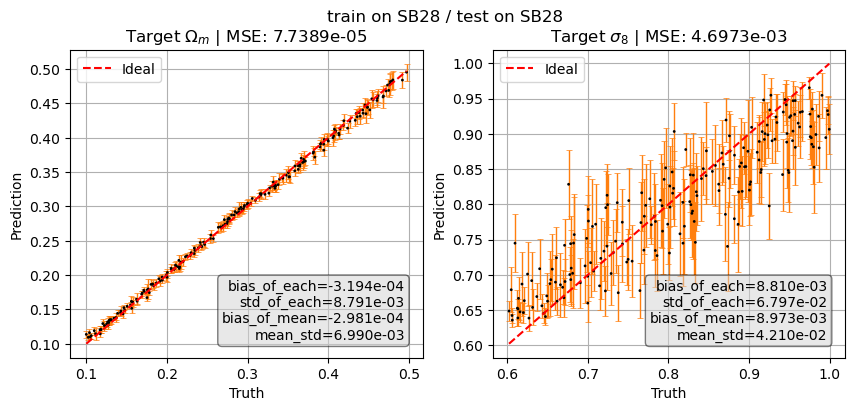

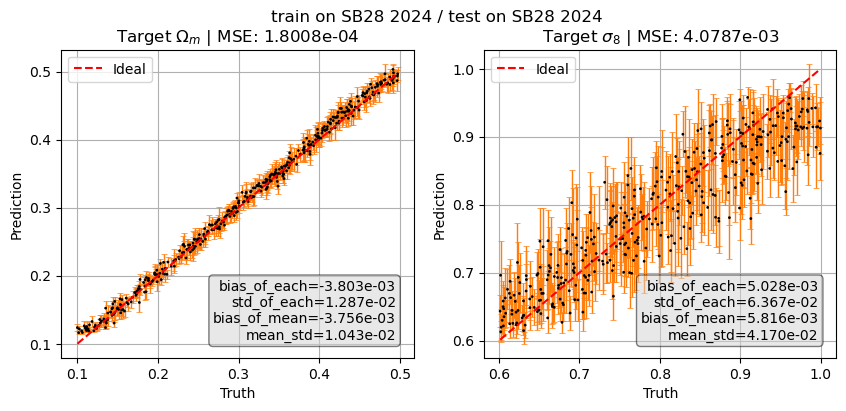

In [10]:
indices = None #range(10) #[0, 1, 2, 40]

if indices is None:
  plot_per_simulation(data28, max_plots=6, chunk_size=15,num_samples=200, title="train on SB28 / test on SB28")
  plot_per_simulation(data28full, max_plots=6, chunk_size=15,num_samples=400, title="train on SB28 2024 / test on SB28 2024")
  #plot_per_simulation(data35_cutout, max_plots=6, chunk_size=15,num_samples=200, title="train on SB28 / test on SB35 cutout")
  #plot_per_simulation(data35_cutout2, max_plots=6, chunk_size=15,num_samples=200, title="train on SB35 cutout / test on SB35 cutout")
  #plot_per_simulation(data28_cutout2, max_plots=6, chunk_size=15,num_samples=200, title="train on SB35 cutout / test on SB28")
  #plot_per_simulation(data35, max_plots=6, chunk_size=30,num_samples=200, title="train on SB35 / test on SB35")
  #plot_per_simulation(data35_half, max_plots=6, chunk_size=30,num_samples=200, title="train on SB35_half / test on SB35")
else:
  plot_per_simulation(data28, max_plots=6, chunk_size=15,sample_indices=indices)
  plot_per_simulation(data35_cutout2, max_plots=6, chunk_size=15,sample_indices=indices)
  plot_per_simulation(data35_cutout, max_plots=6, chunk_size=30,sample_indices=indices)
  plot_per_simulation(data35, max_plots=6, chunk_size=30,sample_indices=indices)
#plt.savefig("train_on_SB28_test_on_both.png")

### Without Monopole

In [11]:
import validator 
importlib.reload(validator)
from validator import *
import structures
importlib.reload(structures)
from structures import *
output_dim = 1#labelsSB28.shape[1]



model = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True)
model.to(device)
model1 = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True)
model1.to(device)
model2 = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True)
model2.to(device)
model3 = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True)
model3.to(device)

model.load_state_dict(torch.load("../data/models/SB28_conv_no_linear_om_no_monopole_best.pt"))
model1.load_state_dict(torch.load("../data/models/SB28_conv_no_linear_sig_no_monopole_best.pt"))
model2.load_state_dict(torch.load("../data/models/SB35_cutout_conv_no_linear_om_no_monopole_best.pt"))
model3.load_state_dict(torch.load("../data/models/SB35_cutout_conv_no_linear_sig_no_monopole_best.pt"))


data28         = get_predictions2(model, model1, val_loaderSB28, _minmaxSB28, device=device)
data35_cutout  = get_predictions2(model2, model3, val_loaderSB35_cutout2, _minmaxSB35, device=device)
data282        = get_predictions2(model2, model3, val_loaderSB28, _minmaxSB35, device=device)
data35_cutout2 = get_predictions2(model, model1, val_loaderSB35_cutout2, _minmaxSB28, device=device)

Validation MSE (average over 2 targets): 3.661353e-03
Validation MSE (average over 2 targets): 3.561628e-03
Validation MSE (average over 2 targets): 4.320678e-03
Validation MSE (average over 2 targets): 4.460645e-03


In [ ]:
import pickle


with open('data28.pkl', 'wb') as f:
    pickle.dump(data28, f)
with open('data35.pkl', 'wb') as f:
    pickle.dump(data35, f)
with open('data35_cutout.pkl', 'wb') as f:
    pickle.dump(data35_cutout, f)
with open('data35_cutout2.pkl', 'wb') as f:
    pickle.dump(data35_cutout2, f)
with open('data28_cutout2.pkl', 'wb') as f:
    pickle.dump(data28_cutout2, f)

In [ ]:
import pickle

with open('data28.pkl', 'rb') as f:
    data28 = pickle.load(f)
with open('data35.pkl', 'rb') as f:
    data35 = pickle.load(f)
with open('data35_cutout.pkl', 'rb') as f:
    data35_cutout = pickle.load(f)
with open('data35_cutout2.pkl', 'rb') as f:
    data35_cutout2 = pickle.load(f)
with open('data28_cutout2.pkl', 'rb') as f:
    data28_cutout2 = pickle.load(f)

Validation MSE (average over 2 targets): 3.661353e-03
Validation MSE (average over 2 targets): 3.561628e-03
Validation MSE (average over 2 targets): 4.320678e-03
Validation MSE (average over 2 targets): 4.460645e-03


/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


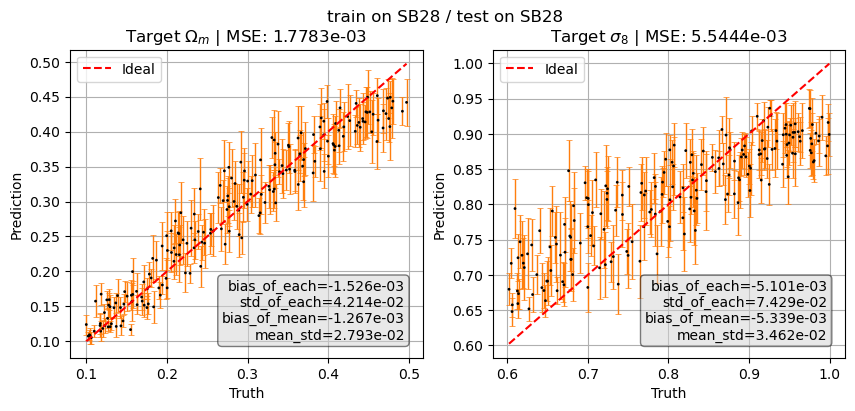

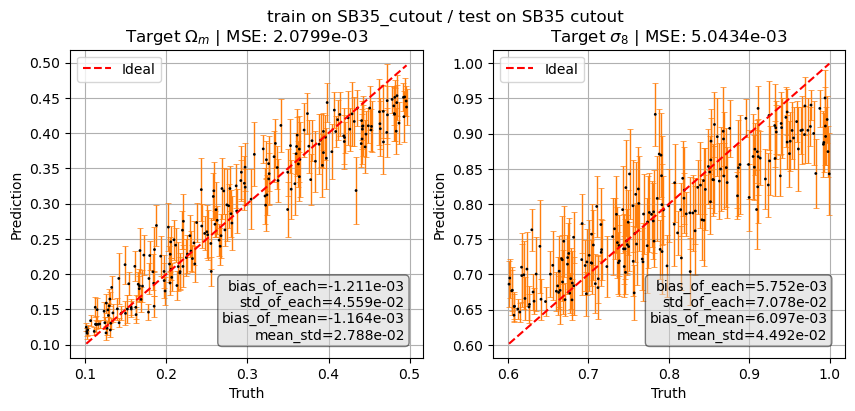

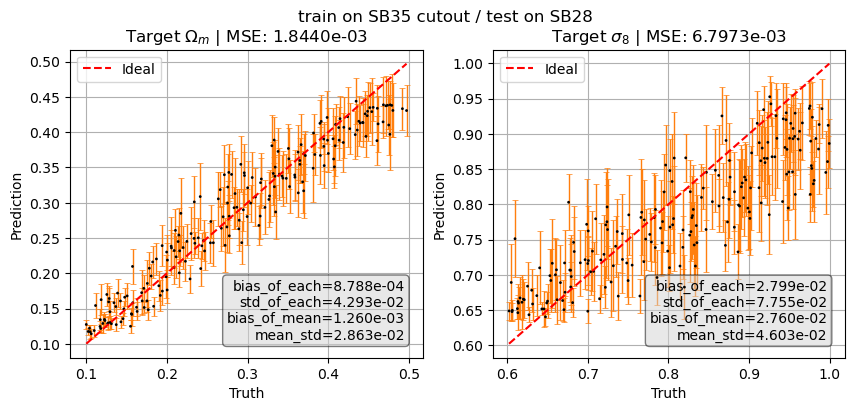

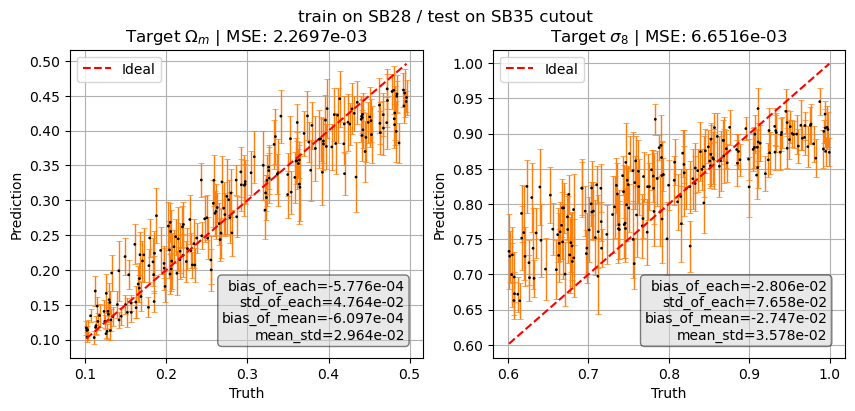

In [12]:
indices = None #range(10) #[0, 1, 2, 40]

if indices is None:
  plot_per_simulation(data28, max_plots=6, chunk_size=15,num_samples=200, title="train on SB28 / test on SB28")
  plot_per_simulation(data35_cutout, max_plots=6, chunk_size=15,num_samples=200, title="train on SB35_cutout / test on SB35 cutout")
  plot_per_simulation(data282, max_plots=6, chunk_size=15,num_samples=200, title="train on SB35 cutout / test on SB28")
  plot_per_simulation(data35_cutout2, max_plots=6, chunk_size=15,num_samples=200, title="train on SB28 / test on SB35 cutout")
else:
  plot_per_simulation(data28, max_plots=6, chunk_size=15,sample_indices=indices)
  plot_per_simulation(data35_cutout2, max_plots=6, chunk_size=15,sample_indices=indices)
  plot_per_simulation(data35_cutout, max_plots=6, chunk_size=30,sample_indices=indices)
  plot_per_simulation(data35, max_plots=6, chunk_size=30,sample_indices=indices)
#plt.savefig("train_on_SB28_test_on_both.png")